In [22]:
# Fonots

# Használathoz fel kell tölteni a metric_____.log filét ha Google Colabon használod.

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import pickle
import joblib

import warnings 
# warnings.filterwarnings("ignore")

from datetime import datetime, date, time

from tensorflow import keras
from tensorflow.keras import layers

from rich.progress import track

from sklearn.linear_model import LinearRegression

print(tf.__version__)

import time
ost = time.time()

ost = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
print(ost)

ost = time.strftime("%H:%M:%S", time.gmtime())
print(ost)

2.10.0
2023-05-03 18:22:12
18:22:12


In [23]:
metric_file_name = 'metric_train_by_none.log'

df = pd.read_csv(metric_file_name, sep=',', header=0)

df.head()

,worker_give_metrics,write_to_csv_time,time,response_time_p95,response_time,worker_number,request_rate,CPU0User%,CPU0Idle%,CPU0Total%,...,[NUMA:0]Mapped,[NUMA:0]Anon,[NUMA:0]AnonH,[NUMA:0]Inactive,[NUMA:0]Hits,[TCPD]InReceives,[TCPD]InDelivers,[TCPD]OutRequests,[TCPD]InSegs,[TCPD]OutSegs
0,192.168.0.170,12:58:36,12:58:3,1149.3470,1149.347000,1,0.1,20.9,66.1,23.6,...,0.0,5.7,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,192.168.0.170,12:58:43,12:58:4,256.6980,256.698000,3,0.1,24.9,54.1,32.0,...,0.0,11.7,10.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,192.168.0.170,12:58:51,12:58:5,1026.9995,473.945364,4,1.1,22.6,71.0,27.6,...,0.0,11.5,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,192.168.0.170,12:59:01,12:59:0,852.6231,393.610000,6,1.0,10.3,86.7,13.2,...,0.0,4.7,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,192.168.0.170,12:59:11,12:59:1,335.5400,257.874455,5,1.1,12.2,84.5,15.2,...,0.0,8.0,7.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df['worker_give_metrics'].unique()

array(['192.168.0.170'], dtype=object)

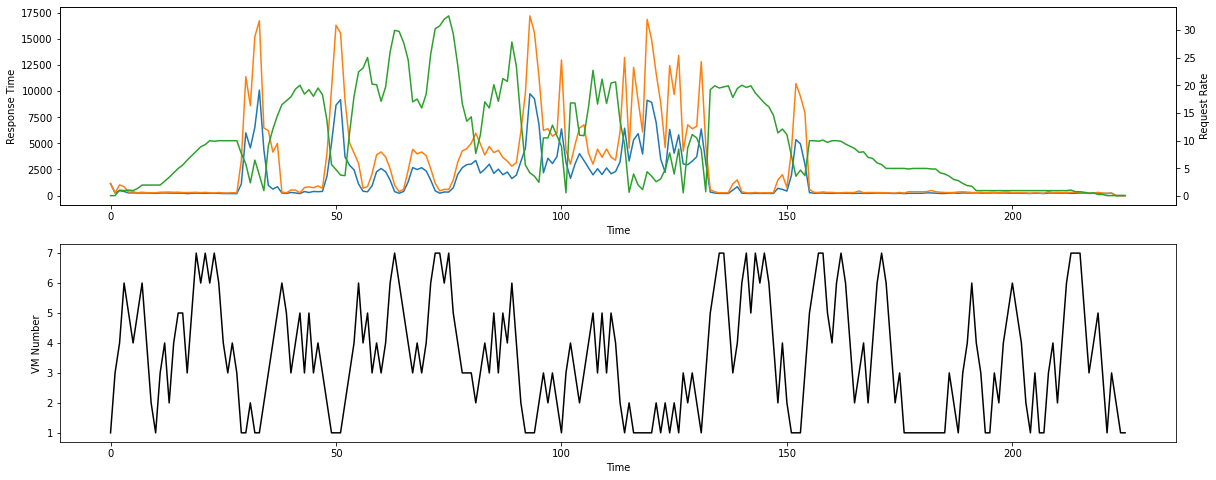

In [25]:

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(20, 8))

ax1.plot(df['response_time'], color = 'C0')
ax1.plot(df['response_time_p95'], color = 'C1')

ax2 = ax1.twinx()

ax2.plot(df['request_rate'], color = 'C2')

ax1.set_xlabel('Time')
ax1.set_ylabel('Response Time')
ax2.set_ylabel('Request Rate')

ax3.plot(df['worker_number'], color = 'black')
ax3.set_xlabel('Time')
ax3.set_ylabel('VM Number')

plt.show()

In [26]:
df.iloc[:, 0:7].describe()

,response_time_p95,response_time,worker_number,request_rate
count,226.000000,226.000000,226.000000,226.000000
mean,2938.372678,1596.335626,3.530973,9.792920
std,4079.774297,2175.033340,1.895355,8.229251
min,0.591000,0.591000,1.000000,0.100000
25%,291.626725,228.190239,2.000000,2.425000
50%,512.510400,266.224050,3.000000,8.250000
75%,4323.766013,2532.064440,5.000000,16.800000
max,17194.278850,10092.898289,7.000000,32.500000


In [27]:
df = df.drop(['CPU1User%', 'CPU1Total%'], axis=1)

In [29]:
df = df.drop(['[DSK:sda]WKBytes',
              '[DSK:sda]Request',
              '[DSK:sda]QueLen',
              '[DSK:sda]QueLen',
              '[DSK:sda]Wait'], axis=1)

In [30]:
df = df.drop(['[DSK:sda]Util',
              '[NUMA:0]Used',
              '[NUMA:0]Free',
              '[NUMA:0]Slab',
              '[NUMA:0]Mapped'], axis=1)

In [31]:
df = df.drop(['[NUMA:0]Inactive',
              '[NUMA:0]Hits',
              '[TCPD]InReceives',
              '[TCPD]InDelivers',
              '[TCPD]OutRequests',
              '[TCPD]InSegs',
              '[TCPD]OutSegs'], axis=1)

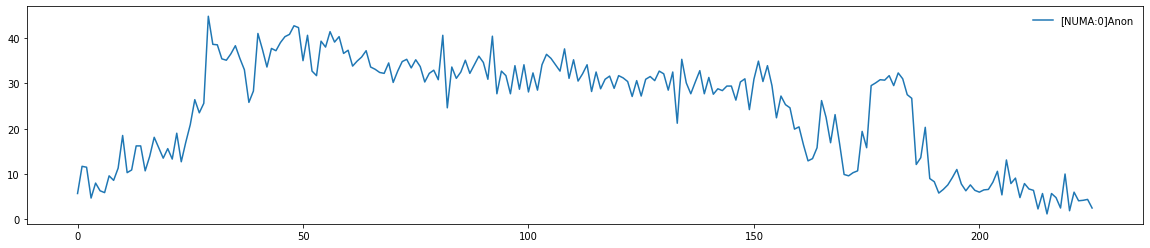

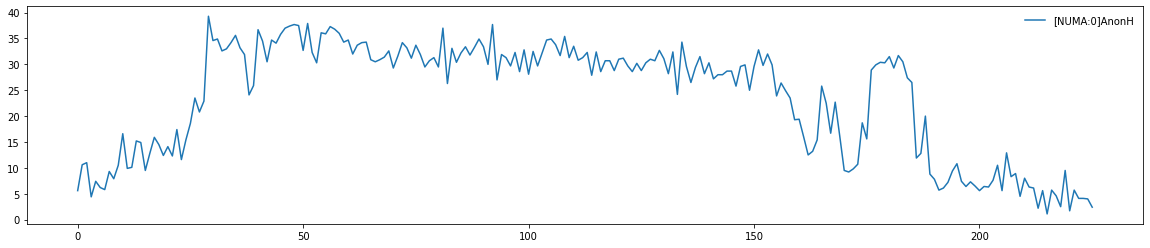

In [32]:
for col_name in df.columns:
    if 'NUMA' in col_name:
        if df[col_name].describe()[2] > 0:
            plt.figure(figsize=(20, 4))
            plt.ticklabel_format(useOffset=False)
            plt.ticklabel_format(style='plain')
            plt.plot(df[col_name], label = col_name)
            plt.legend(frameon=False)
            plt.show()

## CPU Threshod és Response Time Threshold

Két féle skálázást csináltam azonos terheléssel.

A két féle skálázásból származó log filokat beolvasom és összehasonlítom.

In [34]:
train_log_file_name  = 'scaled_train_by_none.log'

cf = pd.read_csv(train_log_file_name, sep=',', header=0)

print(cf.count()[0])

cf['otime'] = cf['time']

cf['time'] = cf['otime'].str[:-1]

cf.head()

281


,time,notification,actual_vm_number_was,actual_vm_number_is,otime
0,12:58:3,Worker 192.168.0.116 added.,1,2,12:58:36
1,12:58:3,Worker 192.168.0.46 added.,2,3,12:58:36
2,12:58:4,Worker 192.168.0.219 added.,3,4,12:58:43
3,12:58:5,Worker 192.168.0.233 added.,4,5,12:58:51
4,12:58:5,Worker 192.168.0.230 added.,5,6,12:58:51


In [35]:
cf['notification'].unique()

array(['Worker 192.168.0.116 added.', 'Worker 192.168.0.46 added.',
       'Worker 192.168.0.219 added.', 'Worker 192.168.0.233 added.',
       'Worker 192.168.0.230 added.', 'Worker 192.168.0.116 removed.',
       'Worker 192.168.0.46 removed.', 'Worker 192.168.0.219 removed.',
       'Worker 192.168.0.233 removed.', 'Worker 192.168.0.230 removed.',
       'Worker 192.168.0.243 added.', 'Worker 192.168.0.243 removed.'],
      dtype=object)

In [29]:
# brutálisan rossz ötlet volt, hogy ezt az adatbázis tegyem össze a másikkal, mivel ha több gépet is hozzáadok
# akkor ebbe több bejegyzés is bele került és teljesen eviszi az egészet

# ezért ezt úgy ahogy van el kell felejtenem a picsába és az lesz a mértékadó, hogy az eslőből
# kinézem, hogy hány gép került hozzáadásra.

In [36]:
mf = df.copy()

mf['actual_vm_number_is'] = mf['worker_number']
mf['actual_vm_number_was'] = mf['worker_number'].shift(1)
mf['actual_vm_number_will'] = mf['worker_number'].shift(-1)

mf['delta_vm'] = mf['actual_vm_number_will'] - mf['actual_vm_number_is']

mf.head()

mf['delta_vm'].unique()

array([ 2.,  1., -1., -2.,  0., nan])

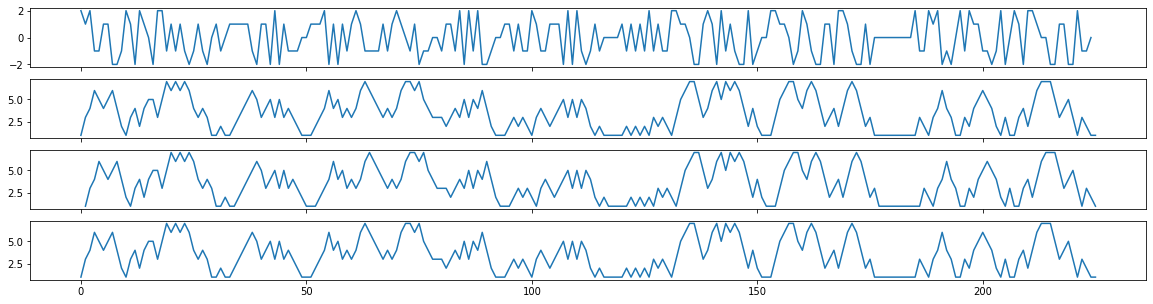

In [37]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 5), sharex=True)

ax1.plot(mf['delta_vm'])
ax2.plot(mf['actual_vm_number_is'])
ax3.plot(mf['actual_vm_number_was'])
ax4.plot(mf['worker_number'])
plt.show()

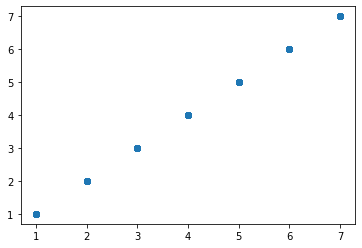

In [38]:
# Ellenőrzés (mert úgy tűnik, hogy a két adatbázisban az éppen aktuális VM szám mindhat egy kicsit mozogna)

plt.scatter(mf['worker_number'], mf['actual_vm_number_is'])
plt.show()

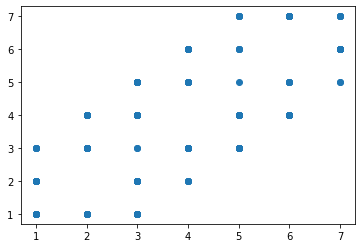

In [39]:
plt.scatter(mf['worker_number'], mf['actual_vm_number_was'])
plt.show()

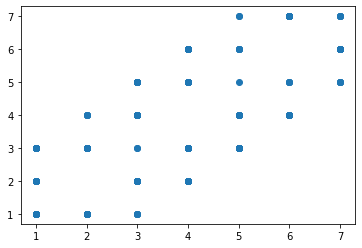

In [40]:
plt.scatter(mf['worker_number'], mf['actual_vm_number_will'])

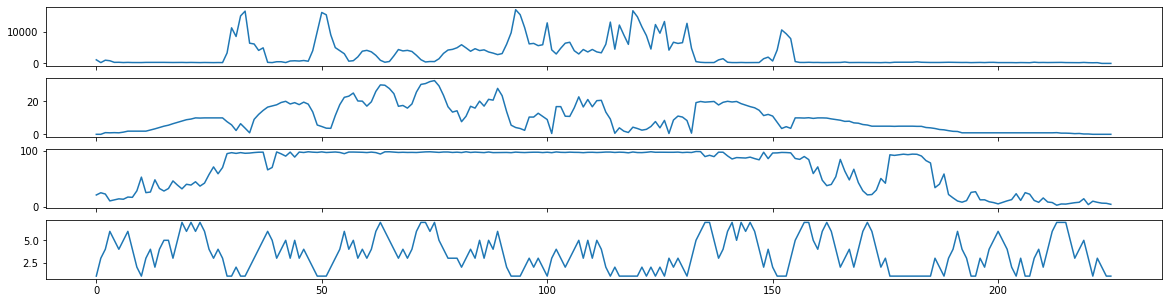

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 5), sharex=True)

ax1.plot(mf['response_time_p95'])
ax2.plot(mf['request_rate'])
ax3.plot(mf['CPU0User%'])
ax4.plot(mf['worker_number'])
plt.show()

In [41]:
# cpu' = c0 + c1 * cpu * worker_number/(worker_number + delta_vm) + c2 * cpu * delta_vm/(worker_number + delta_vm)

# m'   = c0 + c1 · m · w/(w + k) + c2 · m · k/(w + k)

In [59]:
# m'   = c0 + c1 · m · w/(w + k) + c2 · m · k/(w + k)

In [44]:
def plot_true_vs_pred(true, pred):
    plt.axes(aspect='equal')
    plt.scatter(true, pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    _min = np.min((np.min(true), np.min(pred)))
    _max = np.max((np.max(true), np.max(pred)))
    _min -= _min/10
    _max += _max/10
    lims = [_min, _max]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

In [45]:
from sklearn.linear_model import LinearRegression

def create_model_for_metric(columnname: str):
    
    f1 = mf.copy()
    __next_name = columnname + 'Next'
    __prev_name = columnname + 'Prev'

    f1[__next_name] = f1[columnname].shift(-1)
    f1[__prev_name] = f1[columnname].shift(+1)
    
    f1 = f1.dropna()

    # Az lenne a korrekt ha kidobnám azokat ahol nem volt skálázás (delta_vm == 0)
    
    indexAge = f1[ (f1['delta_vm'] == 0) ].index
    f1.drop(indexAge , inplace=True)

    
    __metric_term1 = columnname + '_term1'
    __metric_term2 = columnname + '_term2'
    f1[__metric_term1] = f1[columnname] * f1['worker_number']/(f1['worker_number'] + f1['delta_vm'])
    f1[__metric_term2] = f1[columnname] * f1['delta_vm']/(f1['worker_number'] + f1['delta_vm'])
    
    __metric_term = f1[[__metric_term1, __metric_term2]]
    __metric_next = f1[__next_name]

    lr = LinearRegression(fit_intercept=True)

    rr = lr.fit(__metric_term, __metric_next)
    
    # _ = joblib.dump(lr, './lr/lr_' + columnname + '.joblib', compress=9)

    __fit_score = rr.score(__metric_term, __metric_next)
    
    __fit_coef_ = rr.coef_
    
    __fit_intercept_ = rr.intercept_
    
    __pred_metric = rr.predict(__metric_term)
    
    plot_true_vs_pred(f1[columnname], __pred_metric)

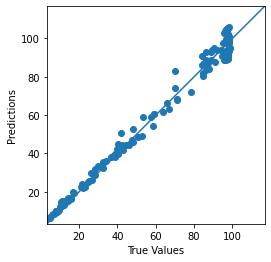

In [46]:
create_model_for_metric('CPU0User%')

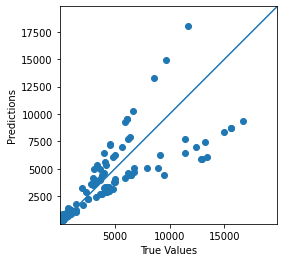

In [47]:
create_model_for_metric('response_time_p95')

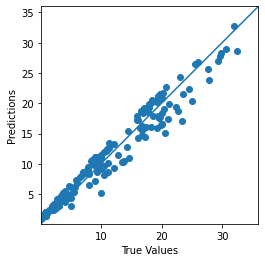

In [48]:
create_model_for_metric('request_rate')

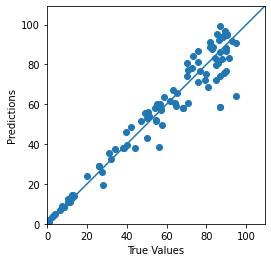

In [49]:
create_model_for_metric('CPU0Idle%')

In [52]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [53]:
mf.columns.difference(mf.select_dtypes('float64').columns)

Index(['actual_vm_number_is', 'time', 'worker_give_metrics', 'worker_number',
       'write_to_csv_time'],
      dtype='object')

In [57]:
# további változók akik ebben a futásban nem voltak túl jók

mf = mf.drop(['CPU1Idle%',
              '[DSK:sda]Reads',
              '[DSK:sda]RMerge'], axis=1)

In [58]:
mf.columns

Index(['worker_give_metrics', 'write_to_csv_time', 'time', 'response_time_p95',
       'response_time', 'worker_number', 'request_rate', 'CPU0User%',
       'CPU0Idle%', 'CPU0Total%', '[DSK:sda]RKBytes', '[DSK:sda]WaitR',
       '[DSK:sda]Writes', '[DSK:sda]WMerge', '[DSK:sda]WaitW',
       '[DSK:sda]SvcTim', '[NUMA:0]Anon', '[NUMA:0]AnonH',
       'actual_vm_number_is', 'actual_vm_number_was', 'actual_vm_number_will',
       'delta_vm'],
      dtype='object')

In [59]:
cn = mf.columns.difference(mf.select_dtypes('object').columns)

interact(create_model_for_metric, columnname=cn);

interactive(children=(Dropdown(description='columnname', options=('CPU0Idle%', 'CPU0Total%', 'CPU0User%', '[DS…

In [69]:
# Csak kiviből kipróbálom, hogy milyen érkeket adna az ő linreg beállításaikkal (nem tom melyik, melyik metric)

bvalues = [[1,0,0],
           [0.9448,0.1072,3.0954],
           [0.8954,0.3220,42.3307],
           [1.1008,0.4017,-20.2569],
           [1.0589,0.5713,1.5306],
           [0.6142,0.1733,26.5175],
           [0.9222,0.2059,1.1572],
           [0.7489,0.2851,18.4977]]

# metrics[i]=np.dot(bvalues[i],[(metrics[i]*w)/(w+k),(metrics[i]*k)/(w+k),1])

metrics = [90, 90, 90, 90, 90, 90]
w = 3
k = 1

m = 1

_cpu = np.dot(bvalues[m],[(metrics[m]*w)/(w+k),(metrics[m]*k)/(w+k),1])

print(_cpu)

# Mivel nem tudom, hogy melyik együtthatótk tartoznak a cpu-hoz ezért nem merem biztosan kijelenteni,
# de úgy tűnik, hogy náluk ha egy VM-t hozzáadok akkor csökken a CPU usage érték és nem nő.

# Ennek lehet az az oka is, hogy a Fibonacci CPU REST API-n tanítottam

69.2814


In [60]:

# Csak úgy mondom, hogy gyárilag a Request Rate értéket is becsülni kell a linreg modellel

# Ennek az az oka, hogy mivel elosztott terhelés van, valóban előforudhat és elő is fordul,
# hogy ha egy új VM-t becsatolok a rendszerbe akkor az adott gépre kevesebb bejövő kérés
# fog jutni.


In [62]:
mf.columns

Index(['worker_give_metrics', 'write_to_csv_time', 'time', 'response_time_p95',
       'response_time', 'worker_number', 'request_rate', 'CPU0User%',
       'CPU0Idle%', 'CPU0Total%', '[DSK:sda]RKBytes', '[DSK:sda]WaitR',
       '[DSK:sda]Writes', '[DSK:sda]WMerge', '[DSK:sda]WaitW',
       '[DSK:sda]SvcTim', '[NUMA:0]Anon', '[NUMA:0]AnonH',
       'actual_vm_number_is', 'actual_vm_number_was', 'actual_vm_number_will',
       'delta_vm'],
      dtype='object')

In [72]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

# sets seeds for base-python, numpy and tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [126]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [RT]')
    plt.legend()
    plt.grid(True)
    plt.show()

def ssd(true, pred):
    diff = true.values.ravel() - pred.ravel()
    sser = np.dot( diff, diff )
    return np.round(np.sqrt( sser ), 2)

def create_term_for_metric(columnname: str):
    
    f1 = mf.copy()
    __next_name = columnname + 'Next'
    __prev_name = columnname + 'Prev'

    f1[__next_name] = f1[columnname].shift(-1)
    f1[__prev_name] = f1[columnname].shift(+1)
    
    f1 = f1.dropna()
    # Az lenne a korrekt ha kidobnám azokat ahol nem volt skálázás (delta_vm == 0)
    indexAge = f1[ (f1['delta_vm'] == 0) ].index
    f1.drop(indexAge , inplace=True)

    __metric_term1 = columnname + '_term1'
    __metric_term2 = columnname + '_term2'
    f1[__metric_term1] = f1[columnname] * f1['worker_number']/(f1['worker_number'] + f1['delta_vm'])
    f1[__metric_term2] = f1[columnname] * f1['delta_vm']/(f1['worker_number'] + f1['delta_vm'])
    
    __metric_term = f1[[__metric_term1, __metric_term2]]
    __metric_next = f1[__next_name]
    
    return __metric_term, __metric_next

def create_term_for_prediction(value: float, w: int, k: int):
    
    __metric_term1 = value * w/(w+k)
    __metric_term2 = value * k/(w+k)
    __metric_term = np.array([[__metric_term1, __metric_term2]])
    
    return __metric_term

def calc_pred_for_metric(__metric_term, __metric_next):

    lr = LinearRegression(fit_intercept=True)
    rr = lr.fit(__metric_term, __metric_next)
    __fit_score = rr.score(__metric_term, __metric_next)
    __fit_coef_ = rr.coef_
    __fit_intercept_ = rr.intercept_
    __pred_metric = rr.predict(__metric_term)
    
    return rr


In [66]:
input_variables = ['request_rate',
                   'CPU0User%',
                   '[DSK:sda]Reads',
                   '[NUMA:0]Anon',
                   '[NUMA:0]AnonH']

input_variables = ['request_rate',
                   'CPU0User%',
                   '[DSK:sda]RKBytes',
                   '[DSK:sda]Writes',
                   '[DSK:sda]WaitW',
                   '[NUMA:0]AnonH']

# Összes
input_variables = ['CPU0Idle%', 
                   'CPU0Total%', 
                   '[DSK:sda]RKBytes', 
                   '[DSK:sda]WaitR', 
                   '[DSK:sda]Writes', 
                   '[DSK:sda]WMerge', 
                   '[DSK:sda]WaitW', 
                   '[DSK:sda]SvcTim',
                   '[NUMA:0]Anon',
                   '[NUMA:0]AnonH']


train_features = mf[input_variables]

# train_labels = mf[['response_time_p95']]

train_labels = mf[['response_time']]

In [127]:

LOSS = 'mean_absolute_error'
# LOSS = 'mean_squared_error'
LR   = 0.4
AC   = 'ReLU'


normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

with np.printoptions(precision=2, suppress=True):
    print('Normiler mean:', normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print('Normalized   :', normalizer(first).numpy())

first_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(15, activation=AC),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation=AC),
    tf.keras.layers.Dropout(0.1),
    layers.Dense(units=1)
])

first_model.summary()

first_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=LOSS)


Normiler mean: [[    28.2      71.46  84193.75  91417.62  61022.11 689591.3   43252.75
      24.53     24.53     23.55]]
First example: [[    66.1     23.6  65200.   89096.8  62213.2 641235.6  94161.2      5.7
       5.7      5.6]]
Normalized   : [[ 1.09 -1.36 -2.57 -1.68  0.31 -3.07  6.82 -1.63 -1.63 -1.64]]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_22 (Dense)            (None, 15)                165       
                                                                 
 dropout_8 (Dropout)         (None, 15)                0         
                                                                 
 dense_23 (Dense)            (None, 30)                480       
       

In [129]:
import tensorflow_addons as tfa
import tqdm

# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False)

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

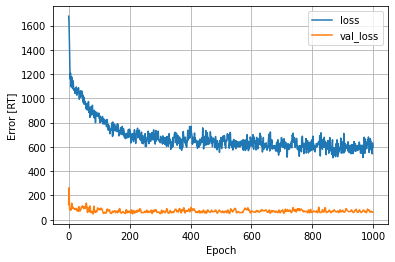

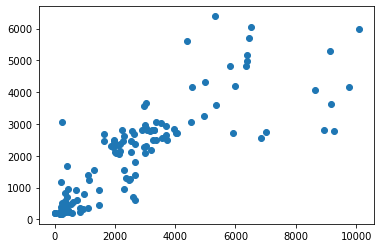

CPU times: user 32 s, sys: 1.27 s, total: 33.2 s
Wall time: 42 s


In [130]:
%%time
history = first_model.fit(
    train_features,
    train_labels,
    epochs = 1000,
    batch_size = 300,
    verbose = 0,
    validation_split = 0.05,
    callbacks=[tqdm_callback])

plot_loss(history)

predicted_labels = first_model.predict(train_features, verbose=0, batch_size=300)

plt.scatter(train_labels, predicted_labels);plt.show()

sse = 17696.94, mean = -351.27, std = 1123.55


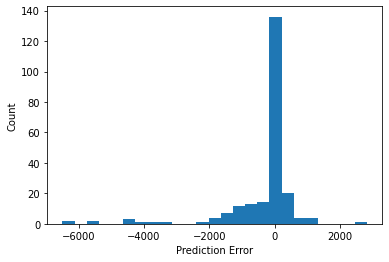

In [131]:
error = predicted_labels - train_labels
error = error.values
sse   = ssd(train_labels, predicted_labels)

print('sse = {:.2f}, mean = {:.2f}, std = {:.2f}'.format(sse, error.mean(), error.std()))
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

In [132]:
# Nem vagyok megelégedve az eredménnyel, mert:

# - a neurális háló nagyon érzékeny mindenre így nehéz összehasonlítanom az eredményeket.

# - nem sikerült még kiválasztanom a jó bemeneti változókat

# Hogy tovább tudjak lépni, most ezektől eltenkintek és elkészítem az a sub-routint ami kiszámolja a becslült
# válaszidőket az egyes fel-, leskálázási értékekehze.

In [133]:
print(input_variables)

['CPU0Idle%', 'CPU0Total%', '[DSK:sda]RKBytes', '[DSK:sda]WaitR', '[DSK:sda]Writes', '[DSK:sda]WMerge', '[DSK:sda]WaitW', '[DSK:sda]SvcTim', '[NUMA:0]Anon', '[NUMA:0]AnonH']


In [136]:
# mindegyikhez elkészíteni hogy mi lenne a fel leskálázás utáni értéke

A = [i for i in range(-7, 8, 1)]

print(A)

# -2.
# inicalizálni egy üres dictianary-t a dict(action, predicted_response_time) pároknak
r = []
al = []
rl = []

# -1.
# kiválasztani, hogy milyen értéket mérek aktuális metrikákként
# ideiglenesen az mf utolsó értékei lesznek a bemenők

__N = -80

__current_response_time = mf['response_time_p95'].values[__N]
__last_metrics = mf[input_variables].values[__N]
__w = mf['worker_number'].values[__N]

print('-----------------------------------------')
print('__last_metrics -> vagyis a current values')
with np.printoptions(precision=2, suppress=True):
    print(__last_metrics)
print('__current_rt -> \t', __current_response_time)
print('__w -> worker_number \t', __w)
print('-----------------------------------------')
print(input_variables)
print('-----------------------------------------')

for a in A:
    
    # Ez kell, hogy a VM szám (w) ne legyen 0
    if __w + a != 0:
    
        # 0.
        # inicializálni egy üres tömböt az input_variable változónak
        _new_train_features = np.zeros((1, mf[input_variables].shape[1]))


        # 1.
        # minden metrikára kiszámolni
        for i, metric in enumerate(input_variables):
            # print(i, metric)
            if metric != 'worker_number':

                # 2.
                # megcsinálni a linreg modelt az adott metrikára (tanítás)
                __metric_term, __metric_next = create_term_for_metric(metric)
                __lr_model = calc_pred_for_metric(__metric_term.values, __metric_next.values)
                
                # 3.
                # elmenetni az adott modelt (amit nem használok sehol)
                # _ = joblib.dump(__lr_model, './lr/lr_' + metric + '.joblib', compress=9)
                
                # 3.
                # az előbbi model alapján egy becslés egy konkrét értékre (value, w, k)
                __metric_term = create_term_for_prediction(__last_metrics[i], __w, a)                
                # print('---a metrica értékének becsése (value, w, k alapján ---')
                # print(__metric_term)
                # print(metric)
                # print(a)
                # print('------------------')
                __pred_metric = __lr_model.predict(__metric_term)
                
                # 4.
                # adott becsült metrikát bele kell helyezni a neurális háló bemeneti változójához
                _new_train_features[0, i] = __pred_metric
                # print(_new_train_features)
            
                
        # 5.
        # megvan az új a-hoz tartozó metika tömb, ez alapján becsüjük meg a válaszidőt
        with np.printoptions(precision=2, suppress=True):
            print(_new_train_features)
        
        # 6.
        # a neurális háló model segítségével megbecsülöm a válaszidőt
        
        __predicted_response_time = first_model.predict(_new_train_features, verbose = 0)
        
        with np.printoptions(precision=2, suppress=True):
            print('action = ', a, ' --> rt --> ', __predicted_response_time, '\n')


[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
-----------------------------------------
__last_metrics -> vagyis a current values
[     7.8     89.9  79020.8  93073.2  64840.4 699306.   42064.4     26.3
     26.3     25.8]
__current_rt -> 	 264.786
__w -> worker_number 	 6
-----------------------------------------
['CPU0Idle%', 'CPU0Total%', '[DSK:sda]RKBytes', '[DSK:sda]WaitR', '[DSK:sda]Writes', '[DSK:sda]WMerge', '[DSK:sda]WaitW', '[DSK:sda]SvcTim', '[NUMA:0]Anon', '[NUMA:0]AnonH']
-----------------------------------------
[[    18.47     26.08  75036.66  93340.14  67015.59 701262.5   43517.43
      -0.21     -0.21      5.5 ]]
action =  -7  --> rt -->  [[205.96]] 

[[     2.04    132.76  82584.99  92778.54  63193.98 697904.78  40937.44
      44.46     44.46     39.65]]
action =  -5  --> rt -->  [[2643.19]] 

[[     6.15    106.09  80697.91  92918.94  64149.38 698744.21  41582.44
      33.29     33.29     31.11]]
action =  -4  --> rt -->  [[5196.8]] 

[[     7.51     97.2   80

In [84]:
# Az egy jó jel, hogyha nem változtatná a vm-ek számát vagyis a k=0, akkor a linreg becsés alapján
# adott új metrika érétkek
# és az ezek alapján adott becslése a válaszidőnek
# nagyon közel áll az éppen mért válaszidő értékéhez,
# ez egy nagyon jó jel, jele annak, hogy a két model jól működik

In [85]:
# A következő feladat

# Ha jól látom ez a Train05 könyvtár

# Tehát ebbe a könyvtárba megírni azt, hogy a feltanított modell alapján skálázzon,.

# És fontos az is, hogy ugyan itt legyen letárolva a terhelést végző jmx profil is,
# hogy ugyan az alapján tudjam terhelni ami alapján tanítottam.
# (egyezzenek a végpontok, stb.)

In [86]:
# Teendő 1

# Kiexportálni az itt feltanított model.

# Keras

first_model.save(os.getcwd())

# first_model.save('model.h5')


INFO:tensorflow:Assets written to: /home/ubuntu/Scaler/Train/Train08/assets


INFO:tensorflow:Assets written to: /home/ubuntu/Scaler/Train/Train08/assets


In [87]:

model = keras.models.load_model(os.getcwd())

# Let's check:
np.testing.assert_allclose(
    first_model.predict(_new_train_features), model.predict(_new_train_features)
)


1/1 [==============================] - 0s 59ms/step


In [88]:
# https://www.tensorflow.org/tutorials/keras/regression

In [137]:

def moric(__n):
    'Az adatsorban minden elemre kiszámolja, hogy mi lett volna a válaszidő különböz k-mellett'
    
    results = []
    results_dict = []

    A = [i for i in range(-7, 8, 1)]

    # n-edik elem lesz kiválasztva a 'mf' dataframeből
    __N = __n

    __current_response_time = mf['response_time_p95'].values[__N]
    __last_metrics = mf[input_variables].values[__N]
    __w = mf['worker_number'].values[__N]

    for a in A:

        # Ez kell, hogy a VM szám (w) ne legyen 0
        if __w + a != 0:

            # 0.
            # inicializálni egy üres tömböt az input_variable változónak
            _new_train_features = np.zeros((1, mf[input_variables].shape[1]))

            # 1.
            # minden metrikára kiszámolni
            for i, metric in enumerate(input_variables):
                # print(i, metric)
                if metric != 'worker_number':

                    # 2.
                    # megcsinálni a linreg modelt az adott metrikára (tanítás)
                    __metric_term, __metric_next = create_term_for_metric(metric)
                    __lr_model = calc_pred_for_metric(__metric_term.values, __metric_next.values)

                    # 3.
                    # az előbbi model alapján egy becslés egy konkrét értékre (value, w, k)
                    __metric_term = create_term_for_prediction(__last_metrics[i], __w, a)                
                    __pred_metric = __lr_model.predict(__metric_term)

                    # 4.
                    # adott becsült metrikát bele kell helyezni a neurális háló bemeneti változójához
                    _new_train_features[0, i] = __pred_metric
                    # print(_new_train_features)

            # 5.
            # megvan az új a-hoz tartozó metika tömb, ez alapján becsüjük meg a válaszidőt
            # with np.printoptions(precision=2, suppress=True):
            #     print(_new_train_features)

            # 6.
            # a neurális háló model segítségével megbecsülöm a válaszidőt
            _ = time.time()
            __predicted_response_time = first_model.predict(_new_train_features, verbose = 0, batch_size=10, use_multiprocessing=True)
            # print(time.time()-_)
            
            # X.
            # megpróbálom felgyorsítani, hogy a numpy számoja a pred válaszidőt
            # W = first_model.get_weights()
            # __px = predict(_new_train_features)
            # print(__px, __predicted_response_time.flatten()[0])
            
            results_dict.append({'action': a, 'prt': __predicted_response_time.flatten()[0]})
            results.append(__predicted_response_time.flatten()[0])
            
    return results


In [138]:
moric(-80)

[205.95569,
 2643.1946,
 5196.8013,
 2278.7966,
 956.2678,
 300.09683,
 236.07175,
 236.07175,
 236.07175,
 236.07175,
 236.07175,
 236.07175,
 236.07175,
 236.07175]

In [139]:
a_prts = []
# for i in mf.shape[0]:
for i in track(range(100)):
    _ = moric(i)
    a_prts.append(_)
    

Output()

In [140]:
a = np.array(a_prts)
a = a

a = a[:,6:]
a.shape

(100, 8)

In [178]:
np.save('a.npy', a)

In [179]:
a = np.load('a.npy')

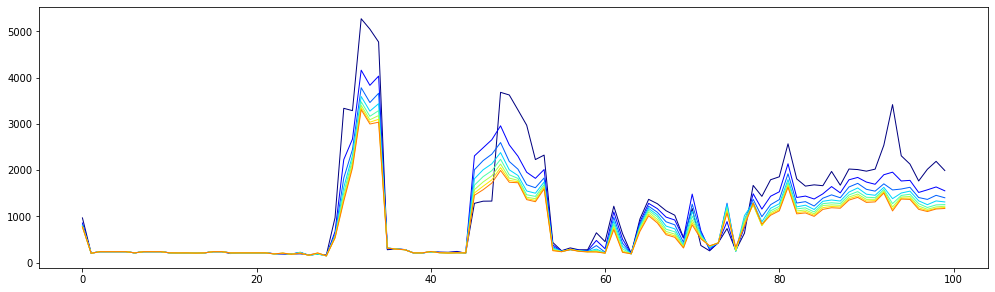

In [141]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 1
#mpl.rcParams['lines.linestyle'] = '-'
#mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colormap = plt.get_cmap('jet')
colors = [colormap(k) for k in np.linspace(0, 1, 10)]

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

plt.figure(figsize=(17, 4.8))
plt.plot(a)
plt.show()

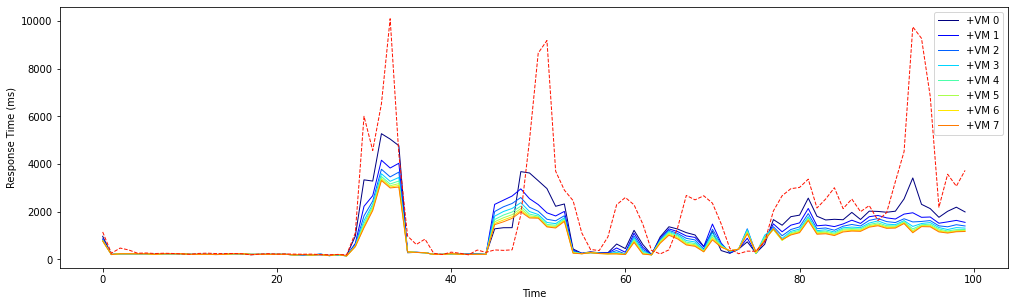

In [150]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 1

colormap = plt.get_cmap('jet')
colors = [colormap(k) for k in np.linspace(0, 1, 10)]

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

plt.figure(figsize=(17, 4.8))

for i in range(a.shape[1]):
    plt.plot(a[:,i], label='+VM ' + str(i))
plt.legend()
plt.plot(mf['response_time'].values[:100], '--')
plt.xlabel('Time')
plt.ylabel('Response Time (ms)')
plt.show()

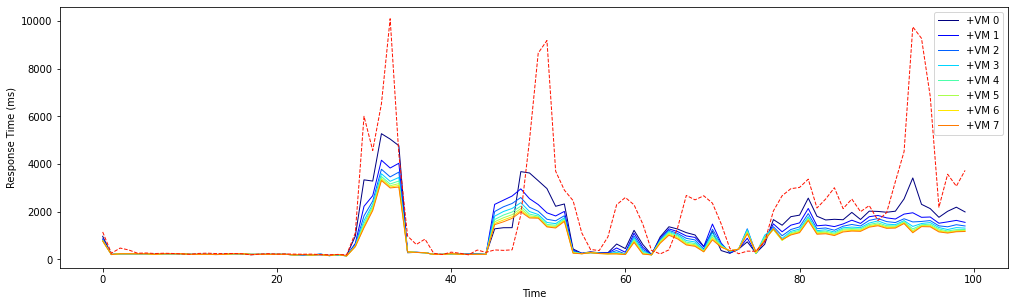

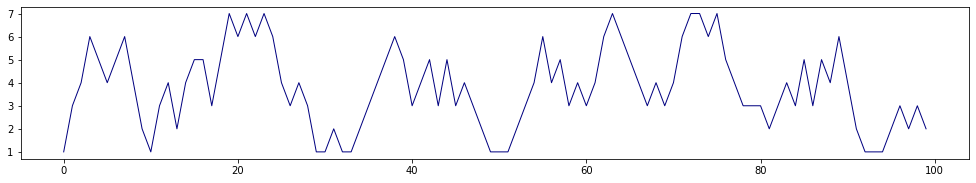

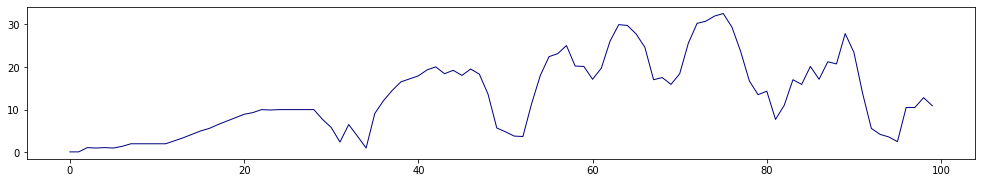

In [165]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

_ig = 100

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 1

colormap = plt.get_cmap('jet')
colors = [colormap(k) for k in np.linspace(0, 1, 10)]

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

plt.figure(figsize=(17, 4.8))

for i in range(a.shape[1]):
    plt.plot(a[:,i], label='+VM ' + str(i))
plt.legend()
plt.plot(mf['response_time'].values[:_ig], '--')
plt.xlabel('Time')
plt.ylabel('Response Time (ms)')
plt.show()

plt.figure(figsize=(17, 2.8))
plt.plot(mf['worker_number'].values[:_ig])
plt.show()

plt.figure(figsize=(17, 2.8))
plt.plot(mf['request_rate'].values[:_ig])
plt.show()

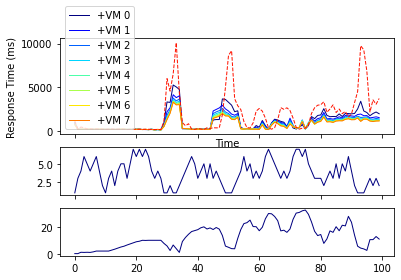

In [177]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

_ig = 100

import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 1

colormap = plt.get_cmap('jet')
colors = [colormap(k) for k in np.linspace(0, 1, 10)]

mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(17, 4.8), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex='col')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]}, sharex='col')


for i in range(a.shape[1]):
    ax1.plot(a[:,i], label='+VM ' + str(i))
ax1.legend()
ax1.plot(mf['response_time'].values[:_ig], '--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Response Time (ms)')

#ax2.figure(figsize=(17, 2.8))
ax2.plot(mf['worker_number'].values[:_ig])

#plt.figure(figsize=(17, 2.8))
ax3.plot(mf['request_rate'].values[:_ig])
plt.show()